In [3]:
import pickle
from  test_city import calculate
from multiprocessing import Pool
import contextily as ctx
import networkx as nx
import osmnx as ox


In [50]:
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        H.add_edge(u, v, length=d['length'])
    print(H)
    del city_id, gdf, polygon_boundary, graph, G

get_graph('R8332101')
get_graph('R1250117')

Graph with 746 nodes and 866 edges
Graph with 2098 nodes and 2544 edges


In [35]:
# city_id: R13470549, Graph with 729 nodes and 1068 edges
# city_id: R4676636, Graph with 3349 nodes and 4519 edges
# city_id: R6564910, Graph with 5485 nodes and 7656 edges
# city_id: R71525, Graph with 9517 nodes and 14837 edges
# city_id: R435514, Graph with 21681 nodes and 30128 edges
# city_id: R2555133, Graph with 17793 nodes and 26845 edges
# city_id: R17140517, Graph with 23897 nodes and 35606 edges
# city_id: R62422, Graph with 28088 nodes and 42098 edges
# city_id: R41485, Graph with 43510 nodes and 60563 edges
# city_id: R207359, Graph with 49514 nodes and 72143 edges

In [17]:
total = 6
points_number = 5000

print('THREADS:', total)
print('POINTS:', points_number)

cities = {
    'Durham': 'R8332101',
    'Kamëz': 'R1250117',
    # 'EKB': 'R1250117',
    # 'BARCELONA': 'R347950',
    'Paris': 'R71525',
    'Prague': 'R435514',
    # 'MSK': 'R2555133',
    # 'SBP': 'R337422',
    # 'SINGAPORE': 'R17140517',
    # 'BERLIN': 'R62422',
    # 'ROME': 'R41485',
    # 'LA': 'R207359',
    # 'DUBAI': 'R4479752',
    # 'RIO': 'R2697338',
    # 'DELHI': 'R1942586',
    # 'KAIR': 'R5466227'
}
total_len = len(cities)
l = list(cities.items())
data = [[l[i: total_len: total],points_number, i + 1, total] for i in range(total)]
# print(data)
with Pool(total) as p:
    p.map(calculate, data)

THREADS: 6
POINTS: 5000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def scatter_visualisation(speed_up, alphas, errors, name='city', output_dir="data/img", show=False):
    plt.figure(figsize=(16, 9))
    
    # Создаем scatter plot
    scatter = plt.scatter(alphas, speed_up, c=errors, cmap='RdYlGn_r', edgecolor='k', alpha=0.75)
    plt.colorbar(scatter, label='Errors, %')
    
    # Устанавливаем подписи для осей
    plt.ylabel('Speed Up')
    plt.xlabel('Alpha')
    plt.title(f'Speed Up vs Alpha with Error Gradient - {name}')
    
    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"scatter_speed_up_vs_alpha_{name}.png")
    plt.savefig(file_path, dpi=600)
    
    print(f"Scatter plot saved to {file_path}")
    if show:
        plt.show()
for n in ['Durham', 'Kamëz', 'Paris', 'Prague']:
    with open(f'clusters_results/2024_06_28/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
        # Извлекаем значения speed_up, alpha и errors в отдельные списки
    speed_up = [results.speed_up[0] for results in data.points_results]
    alphas = [results.alpha for results in data.points_results]
    errors = [np.mean(results.errors) * 100 for results in data.points_results]  # усредняем ошибки и масштабируем

    # Вызываем функцию для создания и сохранения scatter plot
    scatter_visualisation(speed_up, alphas, errors, data.name, show=True)

In [2]:
import requests
import json
import pandas as pd
from tqdm import tqdm

def get_cities_with_population_greater_than_n(n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
        [out:json];
        (
            relation["place"="city"];
            relation["place"="town"];
            relation["place"="village"];
        );
        out;
    """
    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    result = {
        'cities': [],
        'city_ids': [],
        'population_list': [],
        'place': []
    }

    for element in tqdm(data["elements"], leave=False):
        if "population" in element["tags"]:
            population = element["tags"]["population"].replace(" ", "")
            try:
                population = int(population)
                if population >= n:
                    if "name" in element["tags"]:
                        result['cities'].append(element['tags']['name'])  # Добавляем название города в список городов
                        result['city_ids'].append(element['id'])  # Добавляем идентификатор в список идентификаторов
                        result['population_list'].append(element["tags"]["population"].replace(" ", ""))
                        result['place'].append(element['tags']['place'])
            except ValueError:
                # Здесь можно добавить логирование или другую обработку ошибок
                print(f"Не удалось преобразовать население в число для {element['tags'].get('name', 'неизвестного города')}")
    
    return pd.DataFrame(result)  # Возвращаем оба списка    

if __name__ == "__main__":
    min_population = 30000  # Задайте минимальное население
    result = get_cities_with_population_greater_than_n(min_population)

Не удалось преобразовать население в число для San Bernardino
Не удалось преобразовать население в число для Newport
Не удалось преобразовать население в число для Moncton
Не удалось преобразовать население в число для Riverview
Не удалось преобразовать население в число для בני ברק
Не удалось преобразовать население в число для Barnstable
Не удалось преобразовать население в число для Edmonton
Не удалось преобразовать население в число для Myrtleford
Не удалось преобразовать население в число для Tukboy
Не удалось преобразовать население в число для طنجة
Не удалось преобразовать население в число для Fontana
Не удалось преобразовать население в число для Погорелое Городище
Не удалось преобразовать население в число для Belmopan
Не удалось преобразовать население в число для Ontario
Не удалось преобразовать население в число для Ma Gyi Phyu (မန်ကျည်းဖြူ)
Не удалось преобразовать население в число для Gardi Muladub
Не удалось преобразовать население в число для Benque Viejo del Carmen
Н

In [19]:
import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

# Путь к папке с файлами CSV
folder_path = 'data\\csv_1'
files = [f for f in os.listdir(folder_path) if f.startswith('output_R') and f.endswith('.csv')]

# Чтение всех файлов CSV и объединение их в один DataFrame
data_frames = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['R_number'] = file.split('_R')[1].split('.csv')[0]
    data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)
combined_df['speed_up'] = combined_df['dijkstra_time'] / combined_df['times']

# Создание словаря для сопоставления city_ids с названием города
city_id_to_name = dict(zip(result['city_ids'], result['cities']))

# Функция для получения центра города по названию города
def get_city_center_by_name(city_name):
    try:
        gdf = ox.geocode_to_gdf(city_name)
        center = gdf.geometry.centroid.iloc[0]
        return gdf, center
    except Exception as e:
        print(f"Failed to get city center for city: {city_name}, error: {e}")
        return None, None

# Получение уникальных значений R_number
unique_r_numbers = combined_df['R_number'].unique()

# Скачивание данных и создание GeoDataFrame
city_data = []
for R_number in tqdm(unique_r_numbers):
    city_name = city_id_to_name.get(int(R_number))
    if city_name:
        place_name, center = get_city_center_by_name(city_name)
        if place_name is not None:
            city_data.append({
                'R_number': R_number,
                'name_city': city_name,
                'geometry': center
            })

city_gdf = gpd.GeoDataFrame(city_data, geometry='geometry', crs='EPSG:4326')

100%|██████████| 756/756 [00:32<00:00, 22.93it/s]


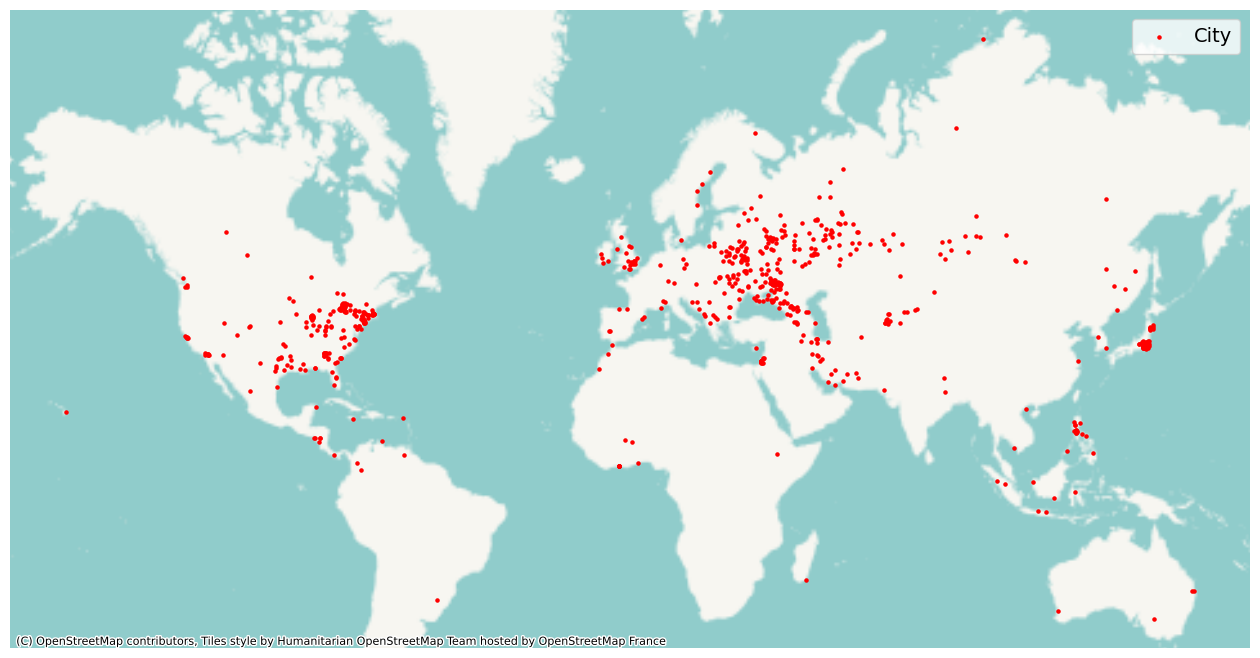

In [89]:
fig, ax = plt.subplots(figsize=(16, 9))
city_gdf = city_gdf.to_crs(epsg=3857)
city_gdf.plot(ax=ax, color='red', markersize=5, label='City')
ctx.add_basemap(ax, zoom=1)
ax.set_axis_off()

# Добавление легенды
ax.legend(loc='upper right', fontsize=14)

plt.savefig('data/img/world_map.png', dpi=200, bbox_inches='tight')
plt.show()

In [11]:
combined_df = pd.read_csv('cities.csv')

In [53]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# Функция для загрузки графа из файлов формата graphml
def load_graph(graph_filename):
    return nx.read_graphml(graph_filename)

# Создание словаря для хранения информации о графах
graph_info = {}

# Проход по уникальным значениям R_number в DataFrame
for R_number in tqdm(combined_df['R_number'].unique()):
    # Формируем путь к файлу графа
    graph_filename = f'data/graphs_1/graph_R{R_number}.graphml'
    
    # Загружаем граф из файла
    G = load_graph(graph_filename)
    
    # Собираем информацию о графе
    # num_nodes = G.number_of_nodes()
    # num_edges = G.number_of_edges()
    # average_clustering = nx.average_clustering(G)
    # density = nx.density(G)
    # diameter = nx.diameter(G)
    degrees = dict(G.degree())
    
    # Сохраняем информацию в словарь
    graph_info[R_number] = {
    # "Number of Nodes": num_nodes,
    # "Number of Edges": num_edges,
    # "Average Clustering": average_clustering,
    # "Density": density,
    # "Diameter": diameter,
    "Average Degrees": np.array(list(degrees.values())).mean(),

    
}
# Создание новых колонок в combined_df и заполнение их значениями из словаря
# combined_df['diameter'] = combined_df['R_number'].map(lambda x: graph_info[x]['Diameter'])
combined_df['average degrees'] = combined_df['R_number'].map(lambda x: graph_info[x]['Average Degrees'])
# combined_df['nodes'] = combined_df['R_number'].map(lambda x: graph_info[x]['Number of Nodes'])
# combined_df['edges'] = combined_df['R_number'].map(lambda x: graph_info[x]['Number of Edges'])
# combined_df['average_clustering'] = combined_df['R_number'].map(lambda x: graph_info[x]['Average Clustering'])
# combined_df['density'] = combined_df['R_number'].map(lambda x: graph_info[x]['Density'])
# combined_df['avg number of points in cluster'] = combined_df['nodes'] / (combined_df['alpha'] * combined_df['nodes'])
# combined_df.to_csv('For_Gosha.csv')

100%|██████████| 756/756 [03:23<00:00,  3.71it/s]


In [54]:
combined_df.to_csv('more_info_for_cities_3.csv', index=False)

In [55]:
combined_df

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k,name_city,node_group,node_group_gap,density,average_clustering,avg number of points in cluster,diameter,average degrees
0,2.408896,0.543499,12.003601,0.011,10.506312,10089445,0.875263,1476,2103,1.424797,90.909091,Копейск,8,"(1453.0, 1629.0]",0.001932,0.045190,90.909091,106,2.849593
1,2.601728,0.457626,11.130596,0.014,10.506312,10089445,0.943913,1476,2103,1.424797,71.428571,Копейск,8,"(1453.0, 1629.0]",0.001932,0.045190,71.428571,106,2.849593
2,7.551250,0.291848,8.531677,0.022,10.506312,10089445,1.231447,1476,2103,1.424797,45.454545,Копейск,8,"(1453.0, 1629.0]",0.001932,0.045190,45.454545,106,2.849593
3,5.011558,0.210539,6.337589,0.045,10.506312,10089445,1.657777,1476,2103,1.424797,22.222222,Копейск,8,"(1453.0, 1629.0]",0.001932,0.045190,22.222222,106,2.849593
4,6.868845,0.206141,5.299418,0.070,10.506312,10089445,1.982541,1476,2103,1.424797,14.285714,Копейск,8,"(1453.0, 1629.0]",0.001932,0.045190,14.285714,106,2.849593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6607,11.824568,0.135997,3.626847,0.089,7.436029,9986400,2.050274,1053,1532,1.454891,11.235955,Невинномысск,5,"(1008.0, 1119.0]",0.002766,0.045806,11.235955,66,2.909782
6608,13.653888,0.158015,3.295653,0.151,7.436029,9986400,2.256314,1053,1532,1.454891,6.622517,Невинномысск,5,"(1008.0, 1119.0]",0.002766,0.045806,6.622517,66,2.909782
6609,12.516316,0.188121,3.310578,0.252,7.436029,9986400,2.246142,1053,1532,1.454891,3.968254,Невинномысск,5,"(1008.0, 1119.0]",0.002766,0.045806,3.968254,66,2.909782
6610,12.271537,0.257031,3.896620,0.418,7.436029,9986400,1.908328,1053,1532,1.454891,2.392344,Невинномысск,5,"(1008.0, 1119.0]",0.002766,0.045806,2.392344,66,2.909782


In [23]:
combined_df.drop('k', axis=1).to_csv('more_info_for_cities.csv', index=False)

Boxplot saved to data\img\boxplot_errors_combined.png


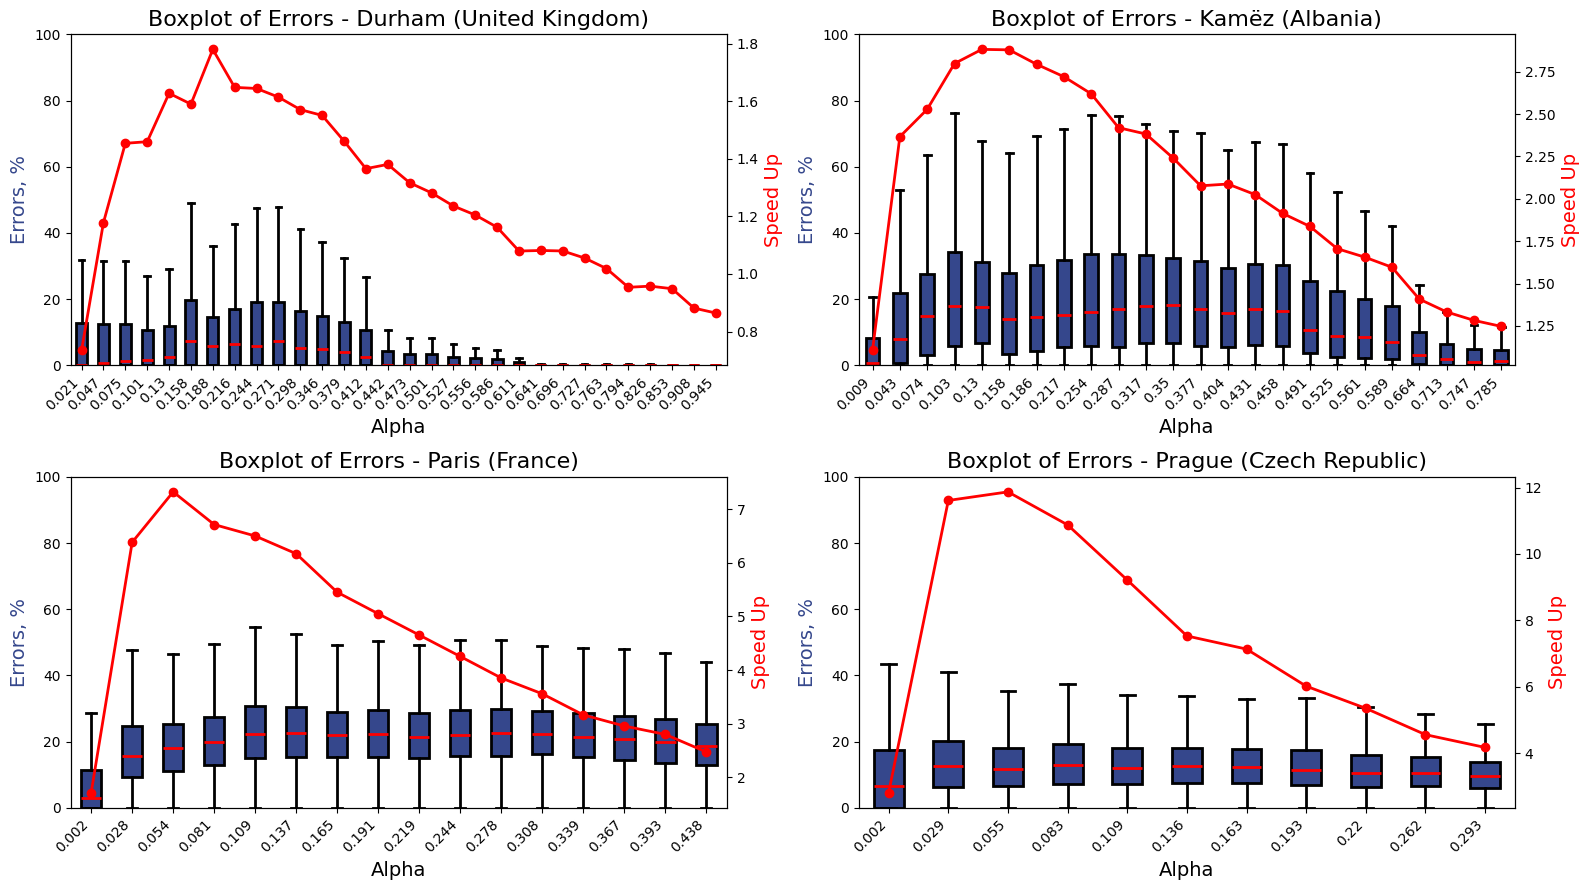

In [64]:
import os
import pickle
import matplotlib.pyplot as plt

def box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, output_dir="data\\img", show=False):
    # Создаем 2x2 подграфики
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    axs = axs.flatten()  # Выравниваем массив подграфиков

    country = {
        'Durham':  'United Kingdom',
        'Kamëz':  'Albania',
        'Paris':  'France',
        'Prague':  'Czech Republic'
    }

    # Параметры для boxplot
    boxprops = {"color": "black", "linewidth": 2, "facecolor": "#35478C"}
    medianprops = {"color": "r", "linewidth": 2}
    whiskerprops = {"color": "black", "linewidth": 2}
    capprops = {"color": "black", "linewidth": 2}

    for i, ax in enumerate(axs):
        # Создаем boxplot на каждом подграфике
        ax.boxplot(absolute_errors_list[i], showfliers=False, vert=True, patch_artist=True,
                   medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.set_ylabel('Errors, %', color='#35478C', fontweight=500, fontsize=14)
        ax.set_xlabel('Alpha', fontsize=14)
        ax.set_title(f'Boxplot of Errors - {names[i]} ({country[names[i]]})', fontsize=16)
        ax.set_xticks(range(1, len(alphas_list[i]) + 1))
        ax.set_xticklabels(alphas_list[i])
        ax.set_ylim(0, 100)  # Установка основной вертикальной оси от 0 до 100

        # Наклон текста на оси x
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Создаем второстепенную ось для pfa time
        ax2 = ax.twinx()
        ax2.plot(range(1, len(alphas_list[i]) + 1), pfa_times_list[i], color='r', marker='o', linestyle='-', linewidth=2)
        ax2.set_ylabel('Speed Up', color='r', fontweight=500, fontsize=14)

    # Настройка пространства между подграфиками
    plt.tight_layout()

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, "boxplot_errors_combined.png")
    plt.savefig(file_path, dpi=200, bbox_inches='tight')
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()

# Списки для хранения данных
absolute_errors_list = []
alphas_list = []
pfa_times_list = []
names = ['Durham', 'Kamëz', 'Paris', 'Prague']

for n in names:
    with open(f'clusters_results\\2024_06_28\\{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        speed_up = [i.speed_up[0] for i in data.points_results]

        # Добавляем данные в списки
        absolute_errors_list.append(absolute_errors)
        alphas_list.append(alphas)
        pfa_times_list.append(speed_up)

# Вызываем функцию для создания и сохранения boxplot
box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, show=True)

In [53]:
df = pd.read_csv('cities.csv')

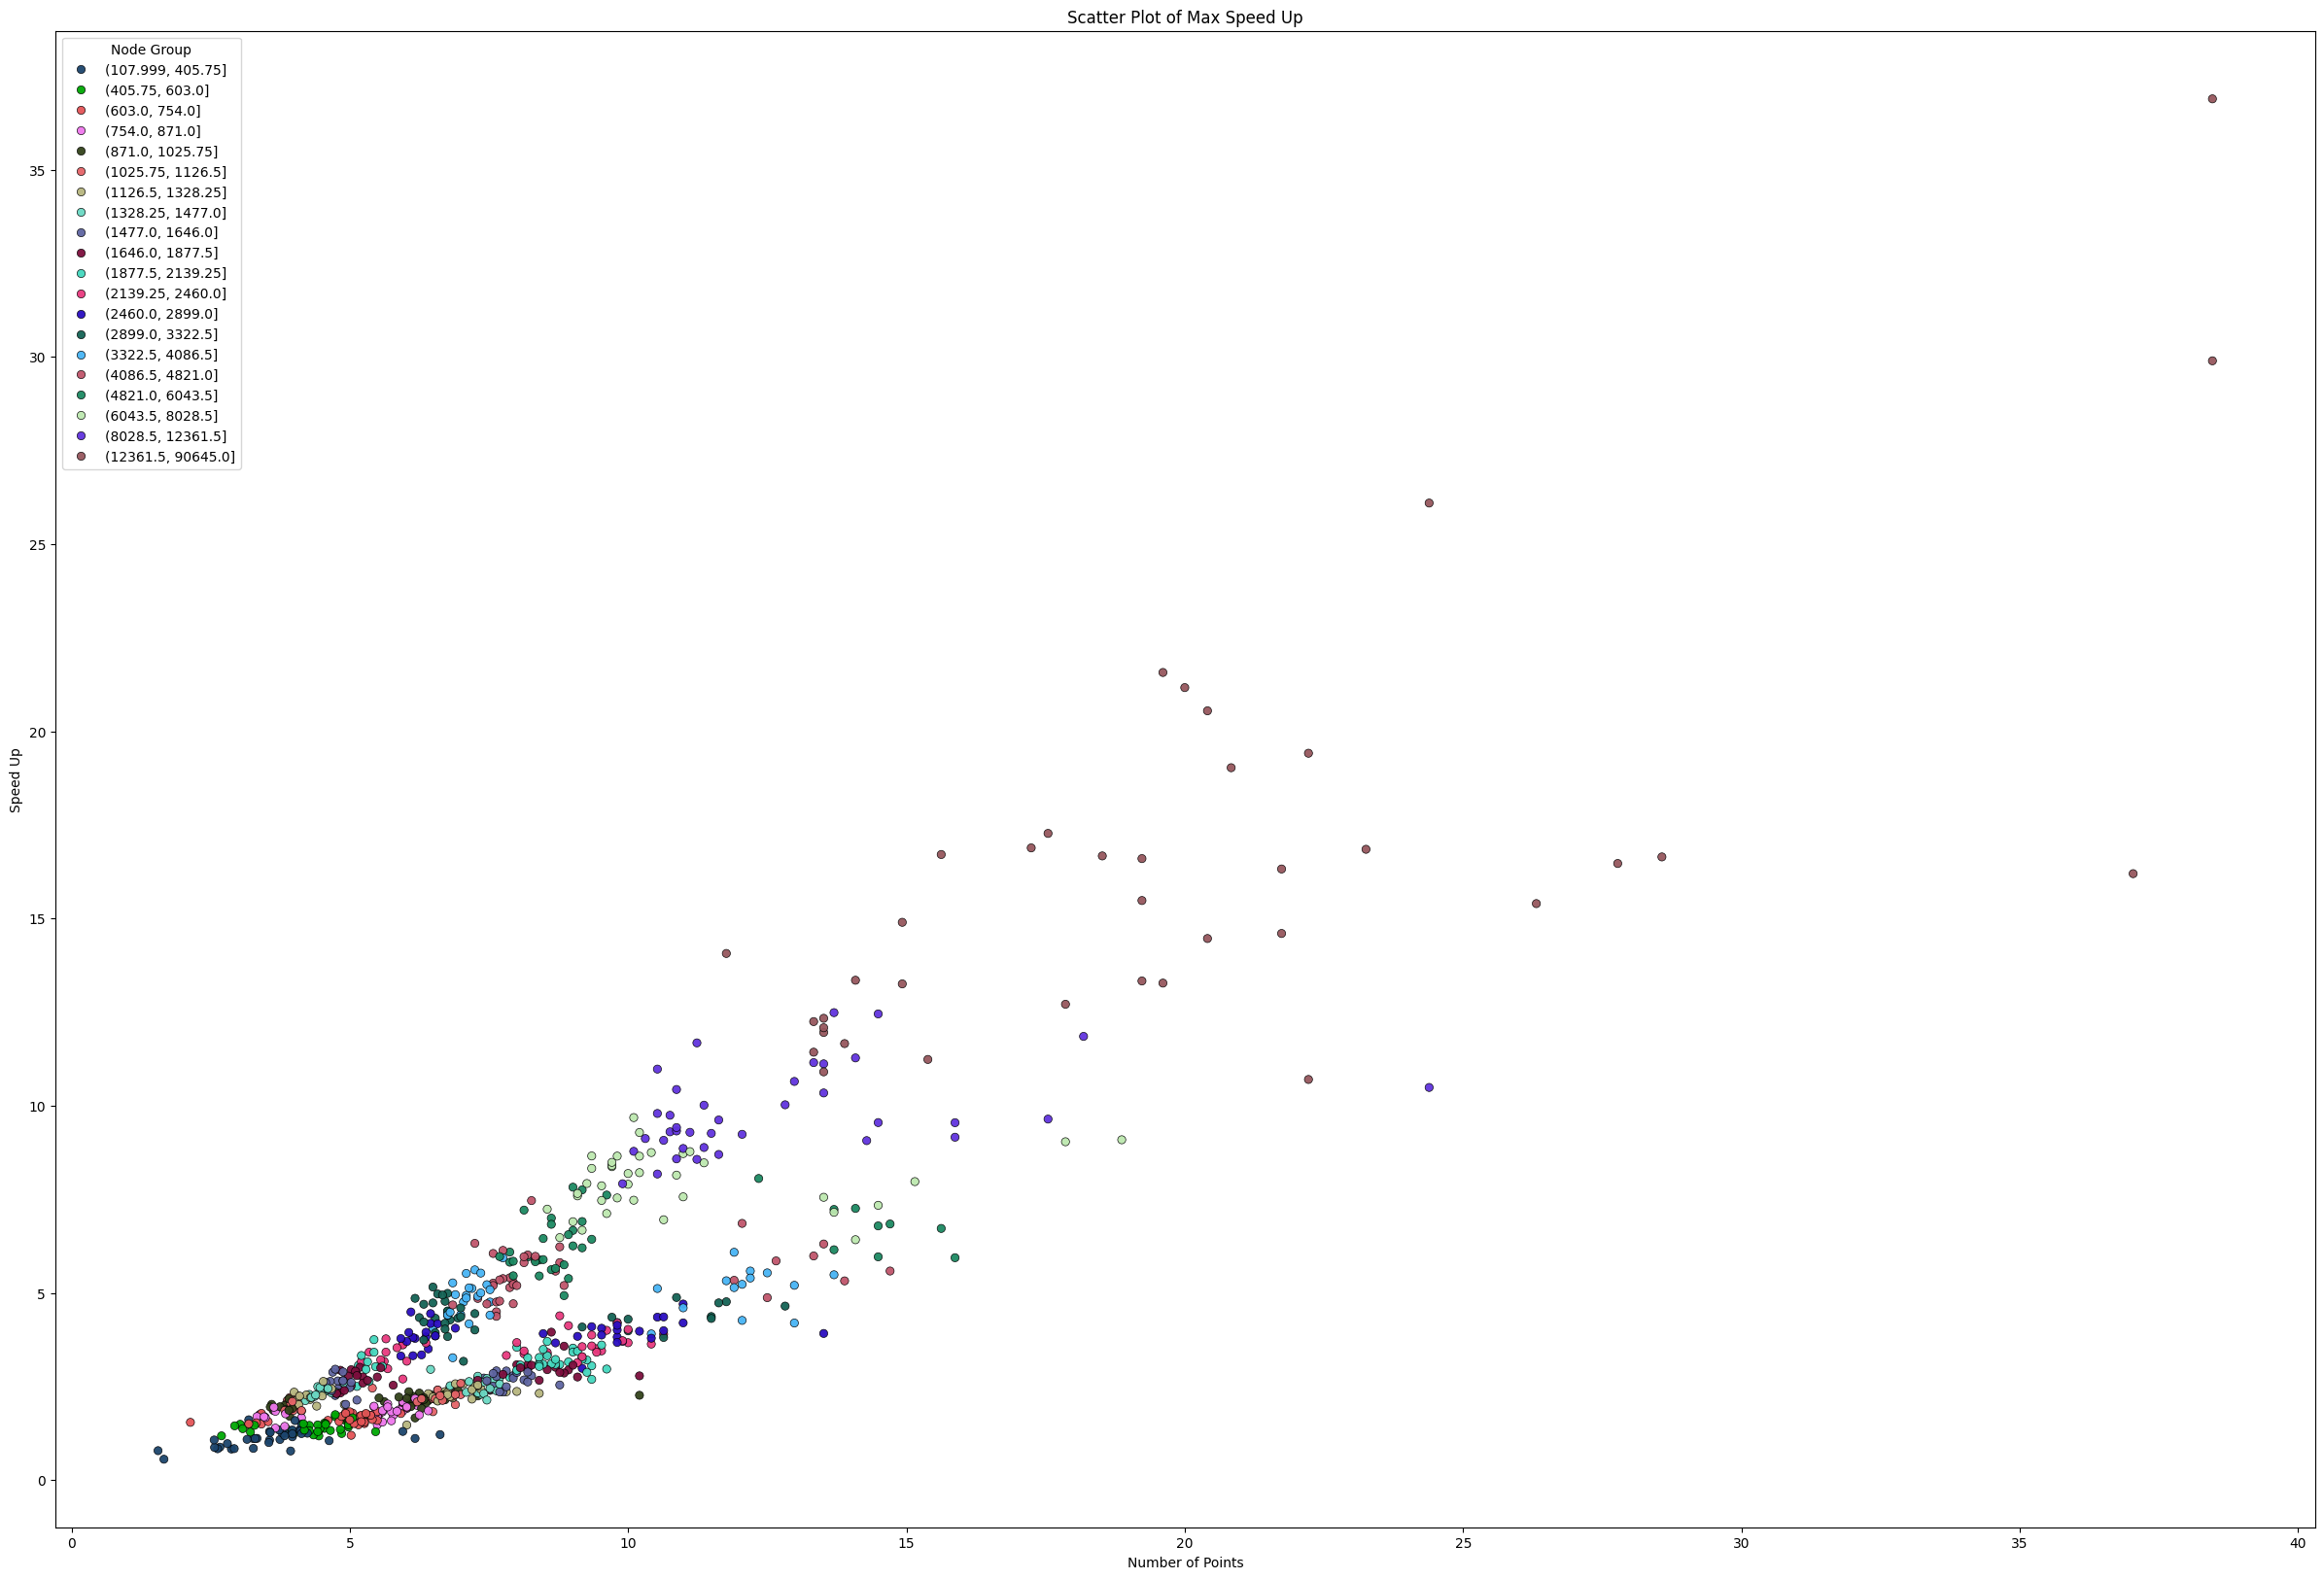

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе квартилей 'nodes'
q = 20
colors = generate_hex_colors(q)
max_speed_up_df['node_group'] = pd.qcut(max_speed_up_df['nodes'], q=q, labels=[i for i in range(q)])
max_speed_up_df['node_group_gap'] = pd.qcut(max_speed_up_df['nodes'], q=q)

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=max_speed_up_df,
    x='k',
    y='speed_up',
    hue='node_group_gap',  # группировка по новой колонке 'node_group'
    palette=colors,  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of Max Speed Up')
plt.xlabel('Number of Points')
plt.ylabel('Speed Up')
plt.legend(title='Node Group')
plt.show()


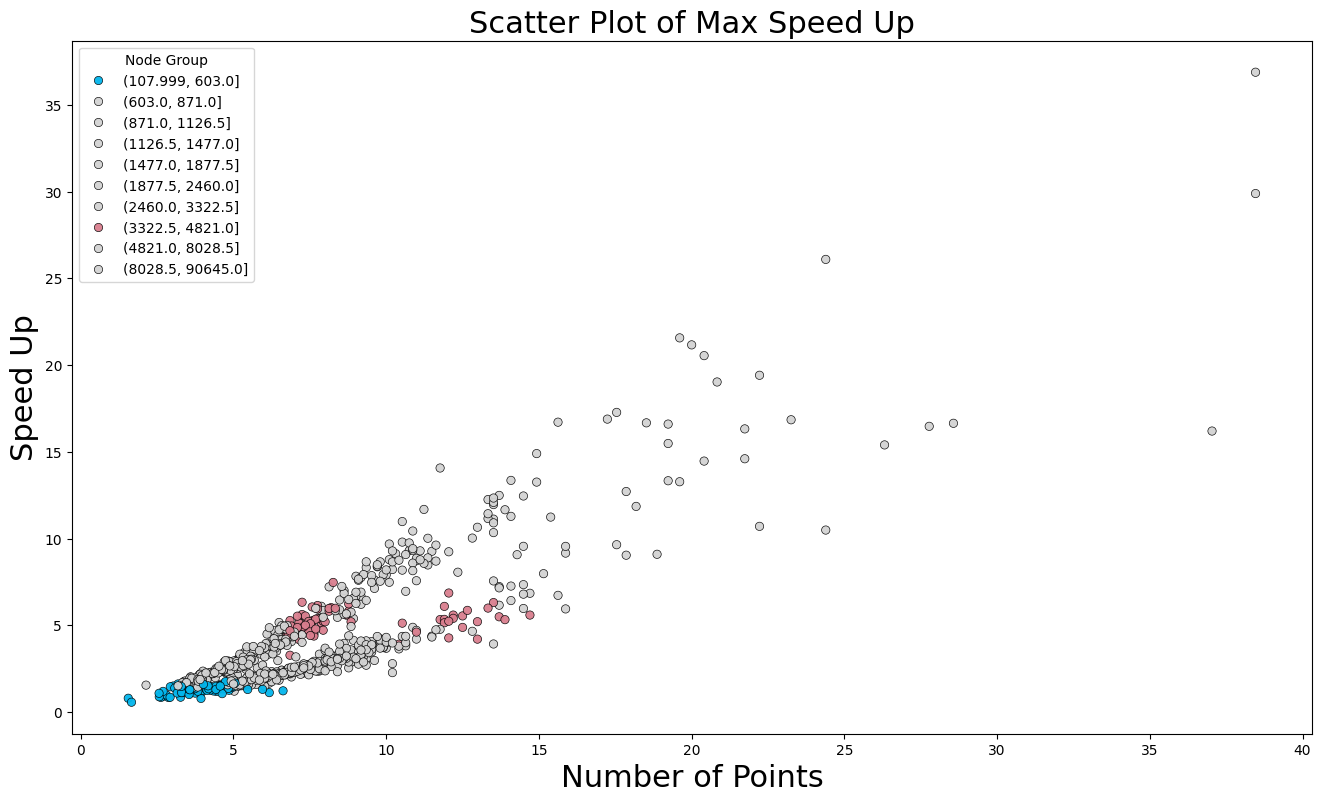

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

# Удаляем ненужную колонку
df = combined_df.drop('Unnamed: 0', axis=1)

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе квартилей 'nodes'
q = 10
colors = generate_hex_colors(q)
max_speed_up_df['node_group'] = pd.qcut(max_speed_up_df['nodes'], q=q, labels=[i for i in range(q)])
max_speed_up_df['node_group_gap'] = pd.qcut(max_speed_up_df['nodes'], q=q)

# Массив классов, которые нужно выделить
selected_classes = [0, 7, 14, 21, 28, 35]  # Пример массива

# Генерация цветовой палитры, включая серый для невыбранных классов
palette = {group: (colors[i] if i in selected_classes else '#D3D3D3') for i, group in enumerate(max_speed_up_df['node_group_gap'].cat.categories)}

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=max_speed_up_df,
    x='k',
    y='speed_up',
    hue='node_group_gap',
    palette=palette,  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of Max Speed Up', fontsize=22)
plt.xlabel('Number of Points', fontsize=22)
plt.ylabel('Speed Up', fontsize=22)
plt.legend(title='Node Group')
plt.savefig('data\\img\\scatter_plot_all_filter.png', dpi=200, bbox_inches='tight')
plt.show()

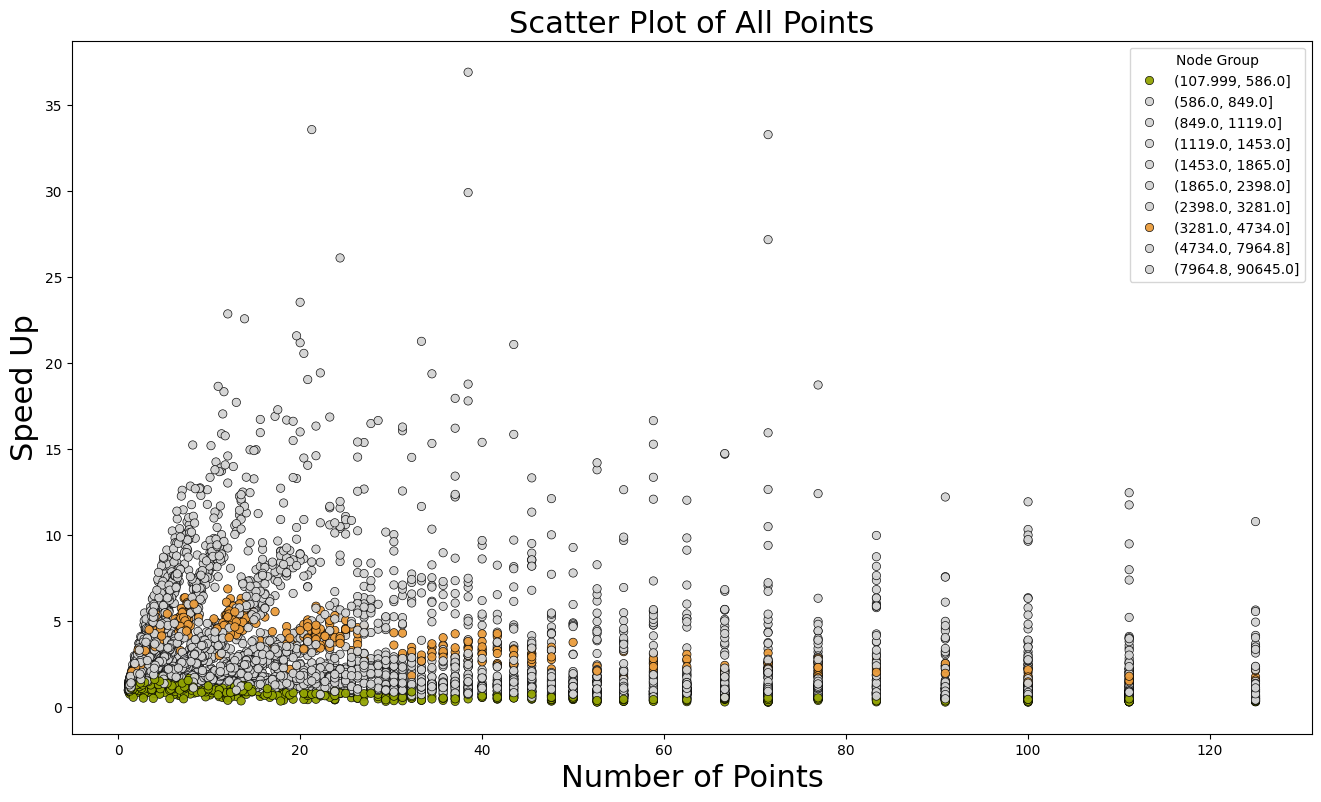

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

# Удаляем ненужную колонку
df = combined_df.drop('Unnamed: 0', axis=1)

# Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
max_speed_up_df = df#.loc[combined_df.groupby('R_number')['speed_up'].idxmax()]

# Создаем группы на основе квартилей 'nodes'
q = 10
colors = generate_hex_colors(q)
max_speed_up_df['node_group'] = pd.qcut(max_speed_up_df['nodes'], q=q, labels=[i for i in range(q)])
max_speed_up_df['node_group_gap'] = pd.qcut(max_speed_up_df['nodes'], q=q)

# Массив классов, которые нужно выделить
selected_classes = [0, 7, 14, 21, 28, 35]  # Пример массива

# Генерация цветовой палитры, включая серый для невыбранных классов
palette = {group: (colors[i] if i in selected_classes else '#D3D3D3') for i, group in enumerate(max_speed_up_df['node_group_gap'].cat.categories)}

# Построение графика с разбиением по группам 'node_group'
plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=max_speed_up_df,
    x='k',
    y='speed_up',
    hue='node_group_gap',  # группировка по новой колонке 'node_group'
    palette=palette,  # цветовая палитра
    edgecolor='black',
    alpha=0.95
)

plt.title('Scatter Plot of All Points', fontsize=22)
plt.xlabel('Number of Points', fontsize=22)
plt.ylabel('Speed Up', fontsize=22)

plt.legend(title='Node Group')
plt.savefig('data\\img\\scatter_plot_all_not_filter.png', dpi=200, bbox_inches='tight')
plt.show()

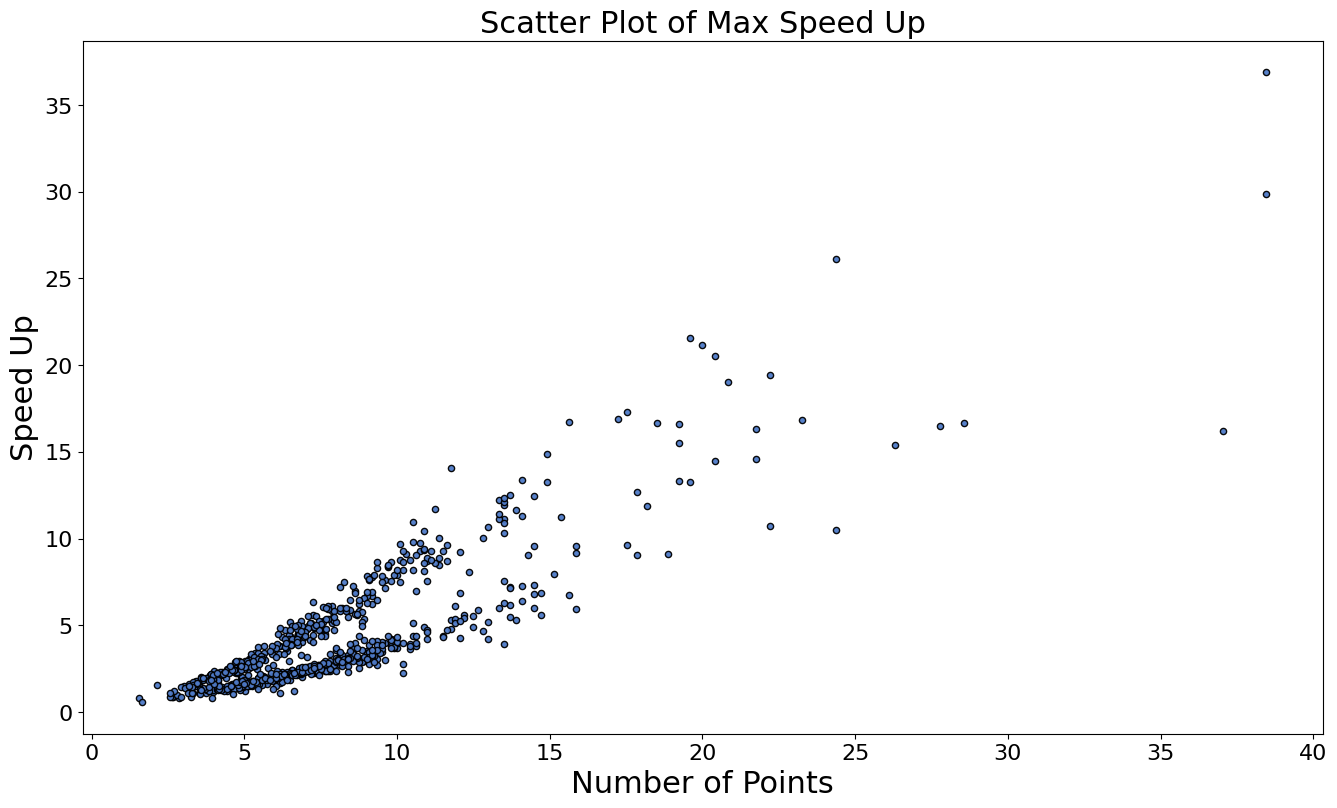

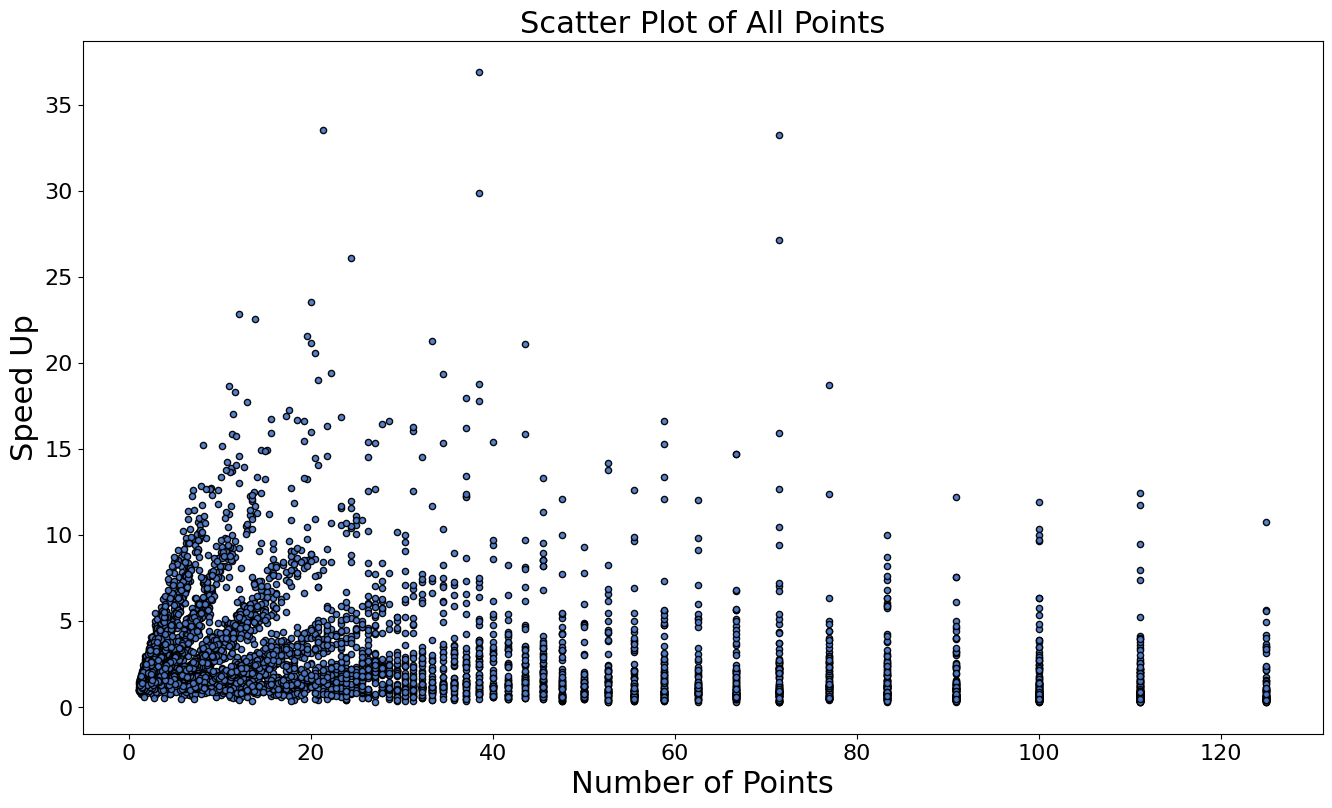

In [74]:
import matplotlib.pyplot as plt

# Второй график
ax = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()].plot(
    figsize=(16, 9), kind='scatter', x='k', y='speed_up', color='#4E7AC7', edgecolor='black', alpha=0.95,  fontsize=16
)
ax.set_xlabel('Number of Points',  fontsize=22)
ax.set_ylabel('Speed Up',  fontsize=22)
ax.set_title('Scatter Plot of Max Speed Up',  fontsize=22)
# Сохранение изображения
plt.savefig('data/img/scatter_plot_filter.png', dpi=200, bbox_inches='tight')
# Отображение графика
plt.show()

# Третий график
ax = combined_df.plot(
    figsize=(16, 9), kind='scatter', x='k', y='speed_up', color='#4E7AC7', edgecolor='black', alpha=0.95,  fontsize=16
)
ax.set_xlabel('Number of Points',  fontsize=22)
ax.set_ylabel('Speed Up',  fontsize=22)
ax.set_title('Scatter Plot of All Points',  fontsize=22)
# Сохранение изображения
plt.savefig('data/img/scatter_plot_all.png', dpi=200, bbox_inches='tight')
# Отображение графика
plt.show()

In [99]:
df['density'] = (2 * df['edges']) / (df['nodes'] * (df['nodes'] - 1))
df.to_csv('cities.csv', index=False)

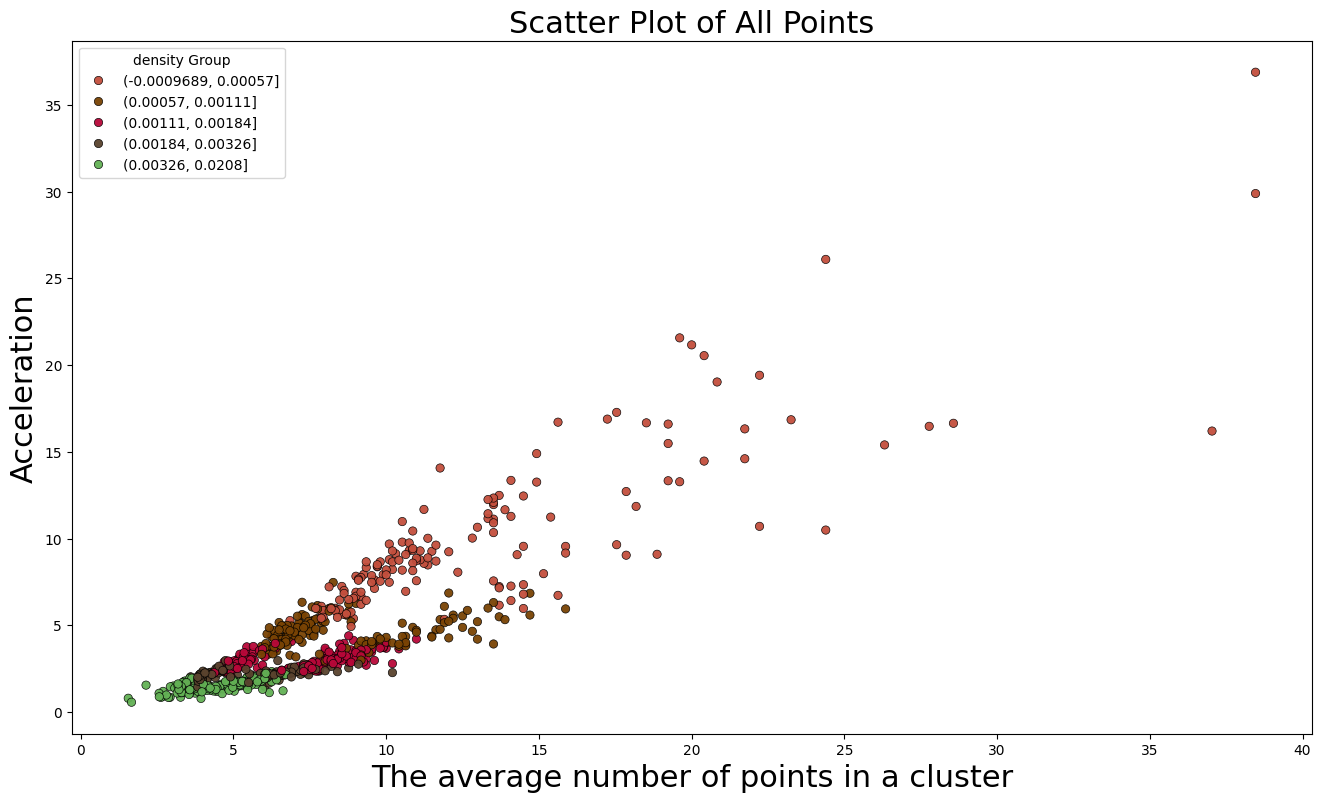

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

def ploting(df, name, highlight2_name, q=10, highlight=False, highlight2=False, selected_classes=[0], save=False, name_fig='figure'):
    # Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
    if highlight:
        max_speed_up_df = df.loc[df.groupby('R_number')['speed_up'].idxmax()]
    else:
        max_speed_up_df = df

    # Создаем группы на основе квартилей 'nodes'
    colors = generate_hex_colors(q)
    max_speed_up_df[f'{name}_group'] = pd.qcut(max_speed_up_df[name], q=q, labels=[i for i in range(q)])
    max_speed_up_df[f'{name}_group_gap'] = pd.qcut(max_speed_up_df[name], q=q)

    if highlight2:
        max_speed_up_df = max_speed_up_df.loc[max_speed_up_df.groupby('R_number')[highlight2_name].idxmax()]

    # Генерация цветовой палитры, включая серый для невыбранных классов
    palette = {group: (colors[i] if i in selected_classes else '#D3D3D3') for i, group in enumerate(max_speed_up_df[f'{name}_group_gap'].cat.categories)}

    # Построение графика с разбиением по группам 'node_group'
    plt.figure(figsize=(16, 9))
    sns.scatterplot(
        data=max_speed_up_df,
        x='avg number of points in cluster',
        y='speed_up',
        hue=f'{name}_group_gap',
        palette=palette,
        edgecolor='black',
        alpha=0.95
    )

    plt.title('Scatter Plot of All Points', fontsize=22)
    plt.xlabel('The average number of points in a cluster', fontsize=22)
    plt.ylabel('Acceleration', fontsize=22)

    plt.legend(title=f'{name} Group')
    if save:
        plt.savefig(f'data\\img\\{name_fig}.png', dpi=200, bbox_inches='tight')
    plt.show()

df = pd.read_csv('more_info_for_cities.csv')
# df = df[df['node_group'].isin([0,1,2,3,4,5,6,7,8,9])]
ploting(df=combined_df, 
        name='density', 
        highlight2_name='speed_up', 
        q=5, 
        highlight=True, 
        highlight2=False, 
        selected_classes=[i for i in range(0, 10, 1)],
        save=False,
        name_fig='Scatter Plot of All Points')

In [106]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from tqdm import trange

# Предположим, что combined_df уже загружен и доступен
df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()][['nodes', 'edges', 'sparsity', 'density', 'average_clustering', 'avg number of points in cluster', 'diameter', 'average degrees']]

n = 100
for i in trange(1, n, 2):
    # Применение t-SNE
    tsne = TSNE(n_components=2, perplexity=i, random_state=42, max_iter=2000)
    tsne_results = tsne.fit_transform(df)

    # Добавление результатов t-SNE в DataFrame
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Применение K-Means
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(tsne_results)
    df['kmeans_labels'] = kmeans_labels

    # Визуализация результатов K-Means
    plt.figure(figsize=(8, 6))
    plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'], c=df['kmeans_labels'], cmap='viridis')
    plt.colorbar()
    plt.title(f'K-Means Clustering on t-SNE Results (Perplexity {i})')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.savefig(f'data/img/t-SNE/t_SNE_{i}_k_means.png')
    plt.close()

    # Применение DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(tsne_results)
    df['dbscan_labels'] = dbscan_labels

    # Визуализация результатов DBSCAN
    plt.figure(figsize=(8, 6))
    plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'], c=df['dbscan_labels'], cmap='viridis')
    plt.colorbar()
    plt.title(f'DBSCAN Clustering on t-SNE Results (Perplexity {i})')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.savefig(f'data/img/t-SNE/t_SNE_{i}_DBSCAN.png')
    plt.close()

100%|██████████| 50/50 [08:39<00:00, 10.39s/it]


C:\Users\local\AppData\Local\Temp\ipykernel_17676\874863225.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()][combined_df['nodes'] < 30000]


<Figure size 800x400 with 0 Axes>

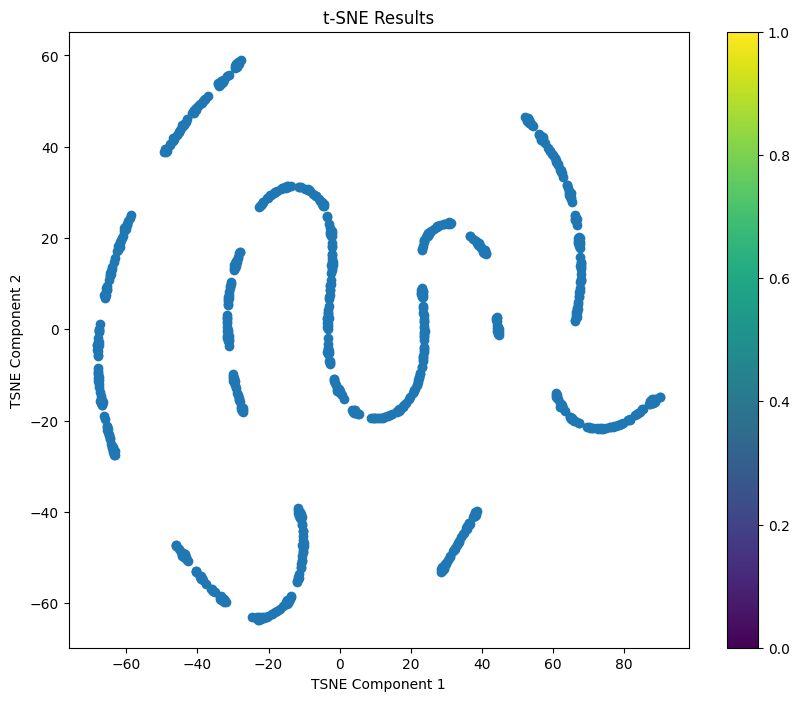

In [154]:
df = combined_df.loc[combined_df.groupby('R_number')['speed_up'].idxmax()][combined_df['nodes'] < 30000]
plt.figure(figsize=(8, 4))
# sns.scatterplot(
#     data=df,
#     x='nodes',
#     y='edges',
#     # hue='node_group_gap',
#     palette='tab10',
#     edgecolor='black',
#     alpha=0.95
# )

# Применение t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42, max_iter=3000)
tsne_results = tsne.fit_transform(df[['speed_up', 'density']])

# Добавление результатов t-SNE в DataFrame
df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

# Визуализация результатов K-Means
plt.figure(figsize=(10, 8))
plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'])
plt.colorbar()
plt.title(f't-SNE Results')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [120]:
df

,error,time_centr,times,alpha,dijkstra_time,R_number,speed_up,nodes,edges,sparsity,k,name_city,node_group,node_group_gap,density,average_clustering,avg number of points in cluster,diameter,average degrees
5546,11.811286,0.853824,5.722600,0.086,27.092109,62145,4.734231,3311,4639,1.401087,11.627907,Магілёў,14,"(3281.0, 3990.0]",0.000847,0.042545,11.627907,86,2.802175
5555,14.019506,2.344734,8.165886,0.123,48.718334,62407,5.966081,4821,6826,1.415889,8.130081,Augsburg,16,"(4734.0, 5957.0]",0.000588,0.067510,8.130081,88,2.831778
5562,12.705562,43.421238,30.855611,0.048,587.061125,62422,19.026073,28088,42098,1.498790,20.833333,Berlin,19,"(11997.0, 90645.0]",0.000107,0.052848,20.833333,176,2.997579
5572,14.393217,0.483166,4.615371,0.118,16.113550,62430,3.491279,2119,2864,1.351581,8.474576,Cottbus - Chóśebuz,10,"(1865.0, 2123.0]",0.001276,0.061853,8.474576,79,2.703162
5581,14.419885,4.685738,10.497882,0.108,83.166768,62644,7.922243,7028,9564,1.360842,9.259259,Bochum,17,"(5957.0, 7964.8]",0.000387,0.078035,9.259259,100,2.721685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,11.085877,0.213889,3.785029,0.132,9.493293,17640743,2.508117,1625,1800,1.107692,7.575758,San Ildefonso,8,"(1453.0, 1629.0]",0.001364,0.024226,7.575758,74,2.215385
2196,13.089229,0.756119,5.505742,0.169,18.255815,17640744,3.315777,2728,3087,1.131598,5.917160,San Miguel,12,"(2398.0, 2800.0]",0.000830,0.017351,5.917160,95,2.263196
2206,13.765325,0.209772,3.611989,0.204,7.291389,17642563,2.018663,1291,1679,1.300542,4.901961,Norzagaray,6,"(1119.0, 1291.0]",0.002016,0.034676,4.901961,64,2.601084
2214,9.887748,1.025475,7.366937,0.096,28.773922,17642564,3.905819,3981,4724,1.186637,10.416667,Santa Maria,14,"(3281.0, 3990.0]",0.000596,0.032990,10.416667,145,2.373273
